# Imputation Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_score(y_true, y_pred):
    return fb_score(y_true, y_pred, beta=1)

def f2_score(y_true, y_pred):
    return fb_score(y_true, y_pred, beta=)

def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return [accuracy, precision, recall, f1]

base_dir = os.path.join(os.getcwd(), os.pardir)

Get the data

In [57]:
impute_dir = os.path.join(base_dir, "data/altered/imputed")
mf_dir = os.path.join(impute_dir, "multiple/missforest")
impute_paths = [(name[5:-4], os.path.join(impute_dir, name)) for name in os.listdir(impute_dir) if name[-4:] == ".csv"]
mf_paths = [(name[:-4], os.path.join(mf_dir, name)) for name in os.listdir(mf_dir)]
impute_paths += mf_paths
all_imputations = [(name, pd.read_csv(path, index_col=0)) for (name, path) in impute_paths]

Sort imputed dataframes

In [65]:
imputations = []
imputations_to_use = [
    "meanmode_impute", 
    "hotdeck_impute", 
    "linlog_reg_impute", 
    "stochastic_linlog_reg_impute", 
    "randomforest_impute", 
    "xgboost_impute",
    "missforest_imputation_1"
]

for (name, df) in all_imputations:
    if name in imputations_to_use:
        if name == "missforest_imputation_1":
            name = "iterative_randomforest"
        else:
            name = name[:-7]
        imputations.append((name, df))

## Classification of deppresion diagnosis

Create a test set from the original data

In [99]:
orig_path = os.path.join(base_dir, "data/altered/maps_feature_mapping.csv")
orig_df = pd.read_csv(orig_path, index_col="X")

orig_X = df.drop(["has_dep_diag"], axis=1)
orig_y = df["has_dep_diag"]

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, random_state=42)

Create list for storing classification results.

In [146]:
clf_results = []

Train base XGBoost classifier without imputations.

In [148]:
xgb = XGBClassifier(objective="binary:logistic")
xgb.fit(orig_X_train, orig_y_train)
score = xgb.score(orig_X_test, orig_y_test)

clf_results.append(("without imputation", score))

print(f"\nXGBoost classification score on non-imputed data: {score}")


XGBoost classification score on non-imputed data: 1.0


Train XGBoost classifier on each imputed dataset.

In [149]:
for (name, df) in imputations:

    X = df.drop("has_dep_diag", axis=1)
    y = df["has_dep_diag"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    xgb = XGBClassifier(objective="binary:logistic")
    xgb.fit(X_train, y_train)
    score = xgb.score(orig_X_test, orig_y_test)

    clf_results.append((name, score))

Plot results

<AxesSubplot:xlabel='classification_accuracy', ylabel='imputation_method'>

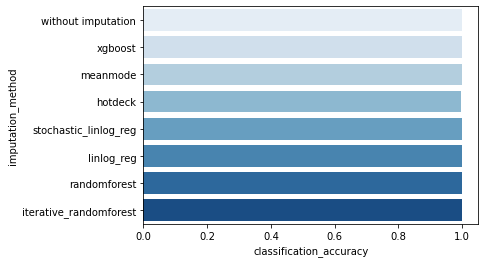

In [150]:
plt_df = pd.DataFrame(clf_results, columns=["imputation_method", "classification_accuracy"])

sns.barplot(x="classification_accuracy", y="imputation_method", data=plt_df, palette="Blues")

## Classification with reduced feature set

Results are likely too accurate due to many other medical features such as `dep_score` and `dep_band` being so closely related.

Let's remove any depression and anxiety related features.

In [225]:
target_feature = ["has_dep_diag"]
non_med_features = [
    "comp_bed_9", "mat_age", "weight_16", "height_16", "iq",
    "comp_noint_bed_16", "comp_int_bed_16", "talk_phon_wend", 
    "text_wend", "talk_mob_wend", "comp_wend", "musi_wend", 
    "read_wend", "work_wend", "alon_wend", "draw_wend", 
    "play_wend", "tv_wend", "out_win_wend", "out_sum_wend", 
    "tran_wend", "talk_phon_week", "text_week", "talk_mob_week", 
    "comp_week", "musi_week", "read_week", "work_week", 
    "alon_week", "draw_week", "play_week", "tv_week", 
    "out_win_week", "out_sum_week", "tran_week", "pat_pres_10", 
    "pat_pres_8", "pat_pres", "num_home", "pat_ses", "mat_ses", 
    "pat_edu", "mat_edu", "parity", "exercise", "child_bull", 
    "phone_14_wend", "phone_14_week", "musi_13", "tv_bed_9", 
    "own_mob", "comp_house", "tv_bed_16", "creat_14", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor", "sex", "birth_order"
]

reduced_df = orig_df[non_med_features + target_feature].copy()

# drop rows with missing values in target feature
reduced_df.dropna(axis=0, subset=target_feature, inplace=True)

reduced_X = reduced_df.drop(["has_dep_diag"], axis=1)
reduced_y = reduced_df["has_dep_diag"]

reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, reduced_y, random_state=42)

reduced_clf_results = []

Train base xgb

In [226]:
xgb = XGBClassifier(objective="binary:logistic")
xgb.fit(reduced_X_train, reduced_y_train)
preds = xgb.predict(reduced_X_test)
metrics = classification_metrics(reduced_y_test, preds)

reduced_clf_results.append(["without imputation"] + metrics)

print(f"\nMetrics for non-imputed data: {metrics}")

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

Metrics for non-imputed data: [0.9193976970770593, 0.3333333333333333, 0.011111111111111112, 0.021505376344086023]


Now lets compare with the imputed datasets.

In [243]:
for (name, df) in imputations:

    X = df[non_med_features]
    y = df[target_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    xgb = XGBClassifier(objective="binary:logistic")
    xgb.fit(X_train, y_train)
    preds = xgb.predict(reduced_X_test)
    metrics = classification_metrics(reduced_y_test, preds)

    reduced_clf_results.append(([name] + metrics)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Plot the results

In [231]:
columns=["imputation_method", "accuracy", "precision", "recall", "f1_score"]
results_df = pd.DataFrame(reduced_clf_results, columns=columns).set_index("imputation_method")

results_df

,accuracy,precision,recall,f1_score
imputation_method,,,,
without imputation,0.919398,0.333333,0.011111,0.021505
xgboost,0.961913,0.912281,0.577778,0.707483
meanmode,0.951284,0.972973,0.400000,0.566929
hotdeck,0.897254,0.303030,0.222222,0.256410
stochastic_linlog_reg,0.900797,0.316667,0.211111,0.253333
linlog_reg,0.948627,0.944444,0.377778,0.539683
randomforest,0.945084,0.937500,0.333333,0.491803
iterative_randomforest,0.950399,1.000000,0.377778,0.548387


<AxesSubplot:title={'center':'Classification Metrics of Depression Diagnosis Using Imputed Datasets'}, ylabel='imputation_method'>

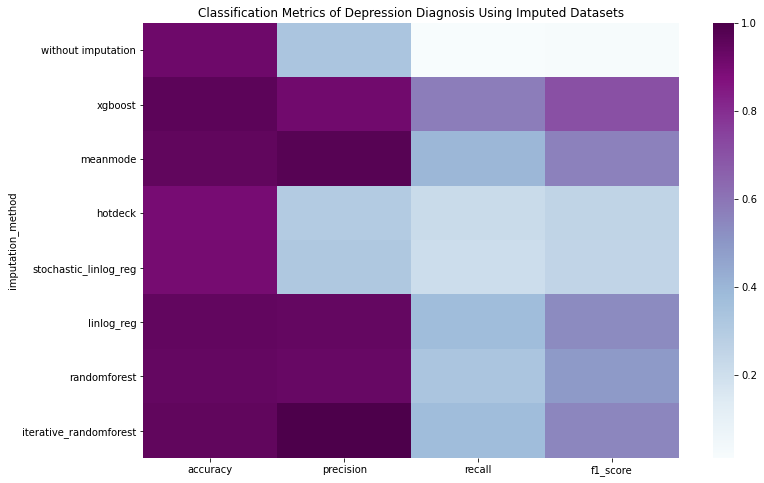

In [242]:
plt.figure(figsize=(12,8))
plt.title("Classification Metrics of Depression Diagnosis Using Imputed Datasets")
sns.heatmap(results_df, cmap="BuPu")
plt.yticks=(["Without Imputation", "XGBoost", "Mean / Mode", "Hot-Deck", "Stochastic Regression", "Regression", "Random Forest", "Iterative Random Forest"])